# Credit Risk Analysis - The Quantum Way

* Why do we need credit risk analysis - Basel II and Basel III
* The Montecarlo methods, where they fall. Their complexity
* Enter QAE - A quick and non rigourous analysis on Brassard, Grover and others work
* QAE for Credit risk - mapping probability distributions


Work based on the following papers:

- <a href="https://www.nature.com/articles/s41534-019-0130-6">Quantum Risk Analysis. Stefan Woerner, Daniel J. Egger.</a> [Woerner2019]
- <a href="https://arxiv.org/abs/1907.03044">Credit Risk Analysis using Quantum Computers. Egger et al. (2019)</a> [Egger2019]
- <a href="http://arxiv.org/abs/quant-ph/0005055">Quantum Amplitude Amplification and Estimation. Gilles Brassard et al.</a>
- And many others, check the references and bibliography and have a blast

### Problem Definition

In this tutorial we want to analyze the credit risk of a portfolio of $K$ assets.
The default probability of every asset $k$ follows a *Gaussian Conditional Independence* model, i.e., given a value $z$ sampled from a latent random variable $Z$ following a standard normal distribution, the default probability of asset $k$ is given by

$$p_k(z) = F\left( \frac{F^{-1}(p_k^0) - \sqrt{\rho_k}z}{\sqrt{1 - \rho_k}} \right) $$

where $F$ denotes the cumulative distribution function of $Z$, $p_k^0$ is the default probability of asset $k$ for $z=0$ and $\rho_k$ is the sensitivity of the default probability of asset $k$ with respect to $Z$. Thus, given a concrete realization of $Z$ the individual default events are assumed to be independent from each other.

We are interested in analyzing risk measures of the total loss

$$ L = \sum_{k=1}^K \lambda_k X_k(Z) $$

where $\lambda_k$ denotes the _loss given default_ of asset $k$, and given $Z$, $X_k(Z)$ denotes a Bernoulli variable representing the default event of asset $k$. More precisely, we are interested in the expected value $\mathbb{E}[L]$, the Value at Risk (VaR) of $L$ and the Conditional Value at Risk of $L$ (also called Expected Shortfall). Where VaR and CVaR are defined as

$$ \text{VaR}_{\alpha}(L) = \inf \{ x \mid \mathbb{P}[L <= x] \geq 1 - \alpha \}$$

with confidence level $\alpha \in [0, 1]$, and

$$ \text{CVaR}_{\alpha}(L) = \mathbb{E}[ L \mid L \geq \text{VaR}_{\alpha}(L) ].$$

For more details on the considered model, see, e.g.,<br>
<a href="https://arxiv.org/abs/1412.1183">Regulatory Capital Modeling for Credit Risk. Marek Rutkowski, Silvio Tarca</a>



The problem is defined by the following parameters:
- number of qubits used to represent $Z$, denoted by $n_z$
- truncation value for $Z$, denoted by $z_{\text{max}}$, i.e., Z is assumed to take $2^{n_z}$ equidistant values in $\{-z_{max}, ..., +z_{max}\}$ 
- the base default probabilities for each asset $p_0^k \in (0, 1)$, $k=1, ..., K$
- sensitivities of the default probabilities with respect to $Z$, denoted by $\rho_k \in [0, 1]$
- loss given default for asset $k$, denoted by $\lambda_k$
- confidence level for VaR / CVaR $\alpha \in [0, 1]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.circuit.library import IntegerComparator, LinearAmplitudeFunction, WeightedAdder
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation, AmplitudeEstimation

from qiskit.finance.applications import GaussianConditionalIndependenceModel as GCI

from kaleidoscope import probability_distribution

IBMQ.load_account()
provider = IBMQ.get_provider()


In [2]:
######################
# Problem parameters #
######################

# Each asset mapped as [default probability, sensitivity o the PDF, loss given default (expressed in '0.000)]

problem_size = 6

total_mortgages = [[0.15, 0.1, 100000],
                    [0.25, 0.05, 200000],
                    [0.2, 0.07, 300000],
                    [0.02, 0.01, 400000],
                    [0.05, 0.05, 300000],
                    [0.2, 0.03, 390000],
                    [0.01, 0.01, 100000],
                    [0.03, 0.09, 120000],
                    [0.2, 0.07, 300000],
                    [0.02, 0.01, 400000],
                    [0.05, 0.05, 300000],
                    [0.25, 0.05, 310000],
                    [0.01, 0.01, 600000],
                    [0.05, 0.01, 800000],
                    [0.04, 0.01, 300000],
                    [0.2, 0.4, 560000],
                    [0.7, 0.10, 100000],
                    [0.04, 0.01, 100000],
                    [0.2, 0.07, 300000],
                    [0.02, 0.01, 400000],
                    [0.05, 0.05, 300000],
                    [0.02, 0.03, 390000],
                    [0.1, 0.01, 200000],
                    [0.04, 0.01, 600000],
                    [0.03, 0.01, 700000]]

# Get only a subset when making the problem smaller
mortgages = total_mortgages[:problem_size]

# Confidence level for VaR and CVaR. On BaselII around 99,9%
alpha = 0.1

IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_qasm_simulator')
#backend = Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2021-02-23 19:28:46,019: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
mortgages

[[0.15, 0.1, 100000],
 [0.25, 0.05, 200000],
 [0.2, 0.07, 300000],
 [0.02, 0.01, 400000],
 [0.05, 0.05, 300000],
 [0.2, 0.03, 390000]]

In [4]:
# Mapping parameters
# Loss Given Default multiplier (we can't map very big numbers, so we eliminate zeroes, from X00,000 -> X0)
lgd_factor = 100000

# Z represents our distribution, discretized with n qubits. The more qubits, the merrier. (I.e. the more values we will be able to approximate)
n_z = 3
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**n_z)

K = len(mortgages)

probability_default = []
sensitivity_z = []
loss_given_default = []
for m in mortgages:
    probability_default.append(m[0])
    sensitivity_z.append(m[1])
    loss_given_default.append(int(m[2] / lgd_factor))   # LGD is simplified, reduced proportionately and taken only the integer part


In [5]:
# TEST removing all sensitivity, making ALL assets losses independent.
#sensitivity_z = np.zeros(K)
#print(sensitivity_z)

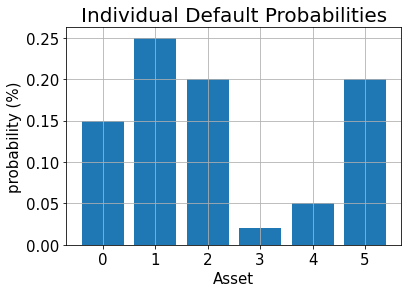

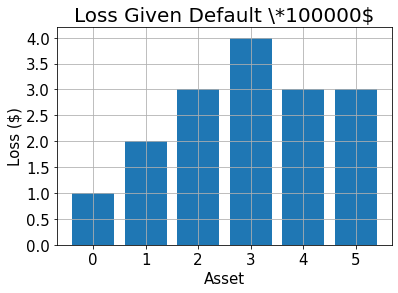

In [6]:
# plot results for default probabilities
plt.bar(range(K), probability_default)
plt.xlabel('Asset', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Individual Default Probabilities', size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

# plot Loss Given Defaults
plt.bar(range(K), loss_given_default)
plt.xlabel('Asset', size=15)
plt.ylabel('Loss ($)', size=15)
plt.title('Loss Given Default \*'+str(lgd_factor) +'$', size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

# Part 1 - Build the model and test classically
_Start slow and easy_

### Uncertainty Model

We now construct a circuit that loads the uncertainty model. This can be achieved by creating a quantum state in a register of $n_z$ qubits that represents $Z$ following a standard normal distribution. This state is then used to control single qubit Y-rotations on a second qubit register of $K$ qubits, where a $|1\rangle$ state of qubit $k$ represents the default event of asset $k$. The resulting quantum state can be written as

$$ |\Psi\rangle = \sum_{i=0}^{2^{n_z}-1} \sqrt{p_z^i} |z_i \rangle \bigotimes_{k=1}^K \left( \sqrt{1 - p_k(z_i)}|0\rangle + \sqrt{p_k(z_i)}|1\rangle\right),$$

Where we denote by $z_i$ the $i$-th value of the discretized and truncated $Z$ [Egger2019].

In [7]:
uncertainty_model = GCI(n_z, z_max, probability_default, sensitivity_z) 
job = execute(uncertainty_model, backend=Aer.get_backend('statevector_simulator'))
probability_distribution(job.result().get_counts())

In [8]:
uncertainty_model = GCI(n_z, z_max, probability_default, sensitivity_z) 
job = execute(uncertainty_model, backend=Aer.get_backend('statevector_simulator'))

p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = uncertainty_model.num_qubits
for i, a in enumerate(job.result().get_statevector()):
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2
    # extract value of Z and corresponding probability    
    # Note Z i mapped in the least significant n_z qubits. We add probabilities for each element in the distribution
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    # Most significant qubits represent 1 for default of that asset.
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += loss_given_default[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
# L = λ1*X1(Z) + λ2*X2(Z) + ... + λn*Xn(Z)
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var+1):], losses[(i_var+1):])/sum(pdf[(i_var+1):])

# Calculate P[L <= VaR[L]]
alpha_point = np.where(values == exact_var)[0].min()
p_l_less_than_var = cdf[exact_var]

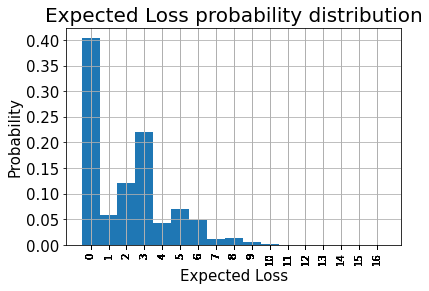

In [9]:
plt.bar(losses, pdf, width=1)
plt.xlabel('Expected Loss', size=15)
plt.ylabel('Probability', size=15)
plt.title('Expected Loss probability distribution', size=20)
plt.xticks(values, size=10, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.show()

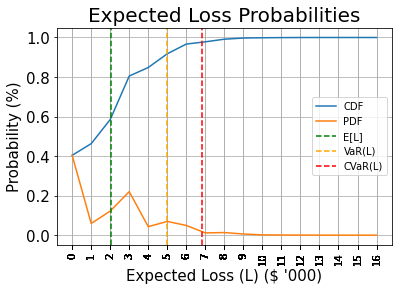

In [10]:
plt.plot(np.unique(values), cdf, label="CDF")
plt.plot(np.unique(values), pdf, label="PDF")
plt.xlabel('Expected Loss (L) ($ \'000)', size=15)
plt.ylabel('Probability (%)', size=15)
plt.title('Expected Loss Probabilities', size=20)
plt.xticks(values, size=10, rotation=90)
plt.yticks(size=15)
plt.axvline(expected_loss, color='green', linestyle='--', label='E[L]')
plt.axvline(exact_var, color='orange', linestyle='--', label='VaR(L)')
plt.axvline(exact_cvar, color='red', linestyle='--', label='CVaR(L)')
plt.legend()
plt.grid()
plt.show()


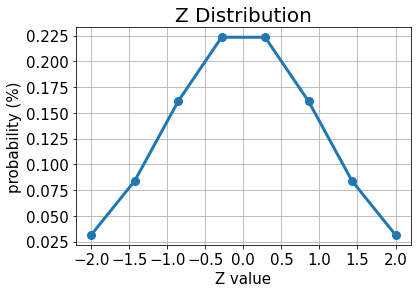

In [11]:
# plot results for Z
plt.plot(z_values, p_z, 'o-', linewidth=3, markersize=8)
plt.grid()
plt.xlabel('Z value', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Z Distribution', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [12]:

print('LGD: ', loss_given_default, ' Total Assets value: $ {0:12,.0f}'.format(sum(loss_given_default)*lgd_factor))
print('Assets: ', K)
print('Assets default Probabilities: ', probability_default)
print('Expected Loss E[L]:                $ {0:12,.0f}'.format(expected_loss*lgd_factor))
print('Value at Risk VaR[L](%.2f):        $ {0:12,.0f}'.format((exact_var*lgd_factor)) % (alpha))
print('P[L <= VaR[L]](%.2f):              %.4f' % (alpha, p_l_less_than_var))
print('Conditional Value at Risk CVaR[L]: $ {0:12,.0f}'.format(exact_cvar*lgd_factor))


LGD:  [1, 2, 3, 4, 3, 3]  Total Assets value: $    1,600,000
Assets:  6
Assets default Probabilities:  [0.15, 0.25, 0.2, 0.02, 0.05, 0.2]
Expected Loss E[L]:                $      204,608
Value at Risk VaR[L](0.10):        $      500,000
P[L <= VaR[L]](0.10):              0.9176
Conditional Value at Risk CVaR[L]: $      683,348


# Part 2 - Expected Loss with Quantum and QAE
_Bring it on_

# Enter QAE

![QAE Circuit](QAE.png)



## QAE
Quantum Amplitude Estimation (QAE) is a fundamental quantum algorithm with the potential to achieve a quadratic speedup for many applications that are classically solved through Monte Carlo (MC) simulation.
While the estimation error of classical MC simulation scales as $O(1/\sqrt{M})$, where M denotes the number of (classical) samples, QAE achieves a scaling of $O(1/M)$ for M (quantum) samples, which implies such quadratic speedup.

The canonical version of QAE is a combination of Quantum Phase Estimation (QPE) and Grover’s Algorithm. Since other QPE-based algorithms are believed to achieve exponential speedup, most prominently Shor’s Algorithm for factoring, it has been speculated as to whether QAE can be simplified such that it uses only Grover iterations without a QPE-dependency. Removing the QPE-dependency would help to reduce the resource requirements of QAE in terms of qubits and circuit depth and lower the bar for practial applications of QAE.

To apply QAE we map the problem in a quantum operator $\mathcal{A}$
$$ \mathcal{A} |0\rangle_{n+1} = \sqrt{1 - a} |\psi_0\rangle_n |0\rangle + \sqrt{a} |\psi_1\rangle_n |1\rangle $$

where $a ∈ [0, 1]$ is the unknown probability of measuring |1>, and $|\psi_0\rangle_n$ and $|\psi_1\rangle_n$ are two normalized states, not necessarily orthogonal. QAE allows to estimate a with high probability such that the estimation error scales as O(1/M), where M corresponds to the number of applications of $ \mathcal{A} $. 

To this extent, an operator $\mathcal{Q} = \mathcal{A} \mathcal{S}_0 \mathcal{A}^\dagger \mathcal{S}_f,$ is defined where 
$ \mathcal{S} \psi_0 = \mathcal{I-2}|\psi_0\rangle_n\langle\psi_0|_n |0\rangle\langle0|$
and $ \mathcal{S}_0 = \mathcal{I-2}|0\rangle_{n+1}
\langle0|_{n+1} $

The canonical QAE follows the form of QPE: it uses m ancilla qubits – initialized in equal superposition – to represent the final result, it defines the number of quantum samples as $M = 2m$ and applies geometrically increasing powers of Q controlled by the ancillas. Eventually, it performs a QFT on the ancilla qubits before they are measured. The measured integer $ y ∈ {0,...,M − 1} $ is mapped to an angle $\theta ̃_a = yπ/M$. Thereafter, the resulting estimate of a is defined as $a ̃ = sin^2 (\theta ̃a )$

## Iterative Quantum Amplitude Estimation
QAE is very expensive, requires many ancillas to obtain a proper estimation of the value and several powers of Q. However we can realize that (from Woerner IQAE paper)
The probability of measuring |1⟩ in the last qubit is given by
$P[|1⟩] = sin^2((2k + 1)θ_a)$

We can then estimate for the last Qubit $Q^k\mathcal{A}|0\rangle_n |0\rangle$ with some confidence interval... and success!

With that we are able to run this problem in noisy computers and increase the problem size (from 4-5 assets to almost 20, peanuts, but bigger peanuts!)




## Expected Loss

To estimate the expected loss, we first apply a weighted sum operator to sum up individual losses to total loss:

$$ \mathcal{S}: |x_1, ..., x_K \rangle_K |0\rangle_{n_S} \mapsto |x_1, ..., x_K \rangle_K |\lambda_1x_1 + ... + \lambda_K x_K\rangle_{n_S}. $$

The required number of qubits to represent the result is given by

$$ n_s = \lfloor \log_2( \lambda_1 + ... + \lambda_K ) \rfloor + 1. $$

Once we have the total loss distribution in a quantum register, we can use the techniques described in [Woerner2019] to map a total loss $L \in \{0, ..., 2^{n_s}-1\}$ to the amplitude of an objective qubit by an operator

$$ | L \rangle_{n_s}|0\rangle \mapsto | L \rangle_{n_s} \left( \sqrt{1 - L/(2^{n_s}-1)}|0\rangle + \sqrt{L/(2^{n_s}-1)}|1\rangle \right),$$

which allows to run amplitude estimation to evaluate the expected loss.


Weighted Adder operator:

$$|q_0 \ldots q_{n-1}\rangle |0\rangle_s \mapsto |q_0 \ldots q_{n-1}\rangle |\sum_{j=0}^{n-1} \lambda_j q_j\rangle_s$$



                   ┌────────┐
          state_0: ┤0       ├ | state_0 * weights[0]
                   │        │ |
          state_1: ┤1       ├ | + state_1 * weights[1]
                   │        │ |
          state_2: ┤2       ├ | + state_2 * weights[2]
                   │        │ |
          state_3: ┤3       ├ | + state_3 * weights[3]
                   │        │
            sum_0: ┤4       ├ |
                   │  Adder │ |
            sum_1: ┤5       ├ | = sum_0 * 2^0 + sum_1 * 2^1 + sum_2 * 2^2
                   │        │ |
            sum_2: ┤6       ├ |
                   │        │
          carry_0: ┤7       ├
                   │        │
          carry_1: ┤8       ├
                   │        │
        control_0: ┤9       ├
                   └────────┘

In [13]:
# add Z qubits with weight/loss 0

# WeightedAdder(num_state_qubits=None, weights=None, name='adder')
# We need as many state qubits as our definition of Z + number of assets: |x1,...xk>|0>ns
# We only add weights to the lgd elements of the sum and add 0 to the Z (not really adding them)

weighted_adder = WeightedAdder(n_z + K, [0]*n_z + loss_given_default)



In [14]:
#weighted_adder.draw()
print(weighted_adder.num_qubits)

19


In [15]:
# Test Aggregator - Just to make sure we understand what it odes and why
# Lets do a quick test to validate the WeightedAdder Qiskit function

test_adder = WeightedAdder(4, [0,0,1,1])    # Adds only the last two state qubits


state_registry = QuantumRegister(test_adder.num_state_qubits, 'state')
sum_registry = QuantumRegister(test_adder.num_sum_qubits, 'sum')
carry_registry = QuantumRegister(test_adder.num_carry_qubits, 'carry')
sum_result = ClassicalRegister(test_adder.num_sum_qubits, 'sum_result')
carry_result = ClassicalRegister(test_adder.num_carry_qubits, 'carry_result')

if test_adder.num_control_qubits > 0:
    control_registry = QuantumRegister(test_adder.num_control_qubits, 'control')
    test_adder_circuit = QuantumCircuit(state_registry, sum_registry, carry_registry, control_registry, sum_result, carry_result)
else:
    test_adder_circuit = QuantumCircuit(state_registry, sum_registry, carry_registry, sum_result, carry_result)

test_adder_circuit.x(state_registry[0])
test_adder_circuit.x(state_registry[1])
test_adder_circuit.x(state_registry[2])
#test_adder_circuit.x(state_registry[3])

test_adder_circuit.append(test_adder, range(test_adder.num_qubits))
test_adder_circuit.measure(sum_registry, sum_result)
test_adder_circuit.measure(carry_registry, carry_result)
test_adder_circuit.draw()



┌───┐┌────────┐         
       state_0: ┤ X ├┤0       ├─────────
                ├───┤│        │         
       state_1: ┤ X ├┤1       ├─────────
                ├───┤│        │         
       state_2: ┤ X ├┤2       ├─────────
                └───┘│        │         
       state_3: ─────┤3 adder ├─────────
                     │        │┌─┐      
         sum_0: ─────┤4       ├┤M├──────
                     │        │└╥┘┌─┐   
         sum_1: ─────┤5       ├─╫─┤M├───
                     │        │ ║ └╥┘┌─┐
       carry_0: ─────┤6       ├─╫──╫─┤M├
                     └────────┘ ║  ║ └╥┘
  sum_result: 2/════════════════╩══╩══╬═
                                0  1  ║ 
                                      ║ 
carry_result: 1/══════════════════════╩═
                                      0

In [16]:
job = execute(test_adder_circuit, backend=Aer.get_backend('statevector_simulator'))
probability_distribution(job.result().get_counts())

### Linear Amplitude Function 

~~~
CLASSLinearAmplitudeFunction(num_state_qubits, slope, offset, domain, image, rescaling_factor=1, breakpoints=None, name='F')
~~~


A circuit implementing a (piecewise) linear function on qubit amplitudes.

An amplitude function 𝐹 of a function 𝑓 is a mapping
$$F|x\rangle|0\rangle = \sqrt{1 - \hat{f}(x)} |x\rangle|0\rangle + \sqrt{\hat{f}(x)} |x\rangle|1\rangle.$$

for a function $ \hat{f}: \{0, ..., 2^n - 1\} \rightarrow [0, 1] $, where |𝑥⟩ is a $n$ qubit state.

This circuit implements F for piecewise linear functions $\hat{f}$. In this case, the mapping F can be approximately implemented using a Taylor expansion and linearly controlled Pauli-Y rotations. This approximation uses a rescaling_factor to determine the accuracy of the Taylor expansion.

In general, the function of interest f is defined from some interval $[a,b]$, 'domain' to $ [c,d]$, the 'image', instead of $ \{1, ..., N\} $ to $[0, 1]$. Usng an affine transformation we can rescale $f$ to $ \hat{f} $ :

$$\hat{f(x)} = \frac{f(\phi(x)) - c}{d - c}$$

with

$\phi(x) = a + \frac{b - a}{2^n - 1} x$

If $ f $ is a piecewise linear function on 'm' intervals $ [p_{i-1}, p_i], i \in \{1, ..., m\} $ with slopes $ \alpha_i $ and offsets $ \beta_i $ it can be written as

$$f(x) = \sum_{i=1}^m 1_{[p_{i-1}, p_i}(x) (\alpha_i x + \beta_i)$$

where $ 1_[a, b] $ is an indication function that is 1 if the argument is in the interval $ [a, b] $ and otherwise 0. The breakpoints $ p_i $ can be specified by the 'breakpoints' argument.

In [17]:

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(loss_given_default)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    weighted_adder.num_sum_qubits,
    slope=slopes, 
    offset=offsets, 
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**weighted_adder.num_sum_qubits-1),  
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
    name="F"
)

In [18]:
objective.decompose().draw()

q34_0: ─────────────────■────────────────────────────────────────────────────
                        │                                                    
q34_1: ─────────────────┼───────────■────────────────────────────────────────
                        │           │                                        
q34_2: ─────────────────┼───────────┼───────────■────────────────────────────
                        │           │           │                            
q34_3: ─────────────────┼───────────┼───────────┼───────────■────────────────
                        │           │           │           │                
q34_4: ─────────────────┼───────────┼───────────┼───────────┼──────────■─────
       ┌──────────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴────┐┌────┴────┐
q35_0: ┤ RY(3π/8) ├┤ RY(π/64) ├┤ RY(π/32) ├┤ RY(π/16) ├┤ RY(π/8) ├┤ RY(π/4) ├
       └──────────┘└──────────┘└──────────┘└──────────┘└─────────┘└─────────┘

In [19]:
job = execute(objective, backend=Aer.get_backend('statevector_simulator'))
probability_distribution(job.result().get_counts())

## Put everything together for the state preparation

In [20]:
# define the registers for convenience and readability
qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
qr_sum = QuantumRegister(weighted_adder.num_sum_qubits, 'sum')
qr_carry = QuantumRegister(weighted_adder.num_carry_qubits, 'carry')
qr_obj = QuantumRegister(1, 'objective')
qr_control = QuantumRegister(1, 'control')


# define the circuit
if weighted_adder.num_control_qubits > 0:
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_control, name='A')
    state_preparation.append(uncertainty_model.to_gate(), qr_state)
    state_preparation.append(weighted_adder.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])
    state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])
    state_preparation.append(weighted_adder.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])
else: 
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name='A')
    state_preparation.append(uncertainty_model.to_gate(), qr_state)
    state_preparation.append(weighted_adder.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])
    state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])
    state_preparation.append(weighted_adder.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])


# draw the circuit
state_preparation.draw()

┌───────┐┌─────────┐      ┌────────────┐
    state_0: ┤0      ├┤0        ├──────┤0           ├
             │       ││         │      │            │
    state_1: ┤1      ├┤1        ├──────┤1           ├
             │       ││         │      │            │
    state_2: ┤2      ├┤2        ├──────┤2           ├
             │       ││         │      │            │
    state_3: ┤3      ├┤3        ├──────┤3           ├
             │       ││         │      │            │
    state_4: ┤4 P(X) ├┤4        ├──────┤4           ├
             │       ││         │      │            │
    state_5: ┤5      ├┤5        ├──────┤5           ├
             │       ││         │      │            │
    state_6: ┤6      ├┤6        ├──────┤6           ├
             │       ││         │      │            │
    state_7: ┤7      ├┤7        ├──────┤7           ├
             │       ││         │      │            │
    state_8: ┤8      ├┤8        ├──────┤8           ├
             └───────┘│         │┌────┐│            │
objective_0: ─────────┤         ├┤5   ├┤            ├
                      │   adder ││    ││   adder_dg │
      sum_0: ─────────┤9        ├┤0   ├┤9           ├
                      │         ││    ││            │
      sum_1: ─────────┤10       ├┤1   ├┤10          ├
                      │         ││  F ││            │
      sum_2: ─────────┤11       ├┤2   ├┤11          ├
                      │         ││    ││            │
      sum_3: ─────────┤12       ├┤3   ├┤12          ├
                      │         ││    ││            │
      sum_4: ─────────┤13       ├┤4   ├┤13          ├
                      │         │└────┘│            │
    carry_0: ─────────┤14       ├──────┤14          ├
                      │         │      │            │
    carry_1: ─────────┤15       ├──────┤15          ├
                      │         │      │            │
    carry_2: ─────────┤16       ├──────┤16          ├
                      │         │      │            │
    carry_3: ─────────┤17       ├──────┤17          ├
                      │         │      │            │
  control_0: ─────────┤18       ├──────┤18          ├
                      └─────────┘      └────────────┘

In [21]:
from qiskit import transpile
print("Required Qubits: ", state_preparation.decompose().num_qubits)

backend = Aer.get_backend('qasm_simulator')
optimized_0 = transpile(state_preparation, backend=backend, seed_transpiler=11, optimization_level=0)
print("No Optimization")
print('gates = ', optimized_0.count_ops())
print('depth = ', optimized_0.depth())

optimized_3 = transpile(state_preparation, backend=backend, seed_transpiler=11, optimization_level=3)
print("High Optimization")
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

Required Qubits:  20
No Optimization
gates =  OrderedDict([('h', 144), ('x', 128), ('cx', 90), ('mcu1', 72), ('ccx', 64), ('u3', 46), ('ry', 14)])
depth =  265
High Optimization
gates =  OrderedDict([('cx', 896), ('cu1', 504), ('t', 224), ('h', 196), ('tdg', 192), ('x', 116), ('u3', 46), ('u1', 16), ('ry', 14)])
depth =  1552


In [22]:
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))

In [23]:
probability_distribution(job.result().get_counts())

## Test clasically


We evaluate going throughn the samples the probability of finding |1>
In principle the QAE or IQAE should approximate such value. _(This might take a while to run... you are going through all samples my friend)_

In [24]:
# evaluate resulting statevector
value = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1):]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == '1':
        value += am**2

In [25]:

print('Exact Expected Loss:   $ {0:12,.0f}'.format(expected_loss*lgd_factor))
print('Exact Operator Value (probability):  %.4f' % value)
print('Mapped Operator value: $ {0:12,.0f}'.format(objective.post_processing(value)*lgd_factor))

Exact Expected Loss:   $      204,608
Exact Operator Value (probability):  0.3567
Mapped Operator value: $      216,229


In [26]:
state_preparation.num_qubits

20

In [27]:

# Where do we want to run it?
#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')

# set target precision and confidence level
epsilon_iae = 0.01
alpha_iae = 0.05

# construct amplitude estimation 
iae = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                  epsilon=epsilon_iae, alpha=alpha_iae,
                                  objective_qubits=[len(qr_state)],
                                  post_processing=objective.post_processing)
result = iae.run(quantum_instance=backend, shots=100)


In [28]:
conf_int = np.array(result['confidence_interval'])
print('Exact value:   $ {0:9,.0f}'.format(expected_loss*lgd_factor))
print('Estimated value: $ {0:9,.0f}'.format(result['estimation']*lgd_factor))
print('Confidence interval: \t[%.0f, %.0f]' % (tuple(conf_int*lgd_factor)))

Exact value:   $   204,608
Estimated value: $   214,559
Confidence interval: 	[204368, 224750]


In [29]:
# Try with "standard" QAE and see what happens

# AmplitudeEstimation(num_eval_qubits, state_preparation=None, grover_operator=None, objective_qubits=None, post_processing=None, phase_estimation_circuit=None, iqft=None, quantum_instance=None, a_factory=None, q_factory=None, i_objective=None)

# evaluation_qubits = 7
# ae = AmplitudeEstimation(evaluation_qubits, state_preparation=state_preparation)
# ia_real_result = ae.run(quantum_instance=backend, shots=1000)

In [30]:
#conf_int = np.array(ia_real_result['confidence_interval'])
#print('Exact value:   $ {0:9,.0f}'.format(expected_loss*lgd_factor))
#print('Estimated value: $ {0:9,.0f}'.format(ia_real_result['estimation']*lgd_factor))
#print('Confidence interval: \t[%.0f, %.0f]' % (tuple(conf_int*lgd_factor)))

## Great, now what?

The expected loss is fine, but this is very easy to calculate even with an excel spreadsheet. However estimating the Cumulative Distribution Function is another story. Classically we would need a very expensive Montecarlo that grows exponentially with the size of the problem.

![CDF Calculation using the Unitary, the weighted adder and the comparator](CDF_calculation_quantum_risk.png)

To estimate the CDF, i.e., the probability $ \mathbb{P} [L  \leq  x] $ , we compute the total loss the same way as before and then apply a comparator.

$$ \begin{split} \mathcal{C}: |L\rangle_n|0> \mapsto \begin{cases} |L\rangle_n|1> & \text{if}\quad L \leq x \\ |L\rangle_n|0> & \text{if}\quad L > x. \end{cases}\end{split} $$

The CDF(𝑥) equals the probability of measuring |1⟩ in the objective qubit. So we appliy IQAE et voilà!



In [31]:
# We use an IntegerComparator
# IntegerComparator(num_state_qubits=None, value=None, geq=True, name='cmp')
# Operator compares basis states |𝑖⟩𝑛 against a classically given integer 𝐿 of fixed value and flips a target qubit if 𝑖≥𝐿 (or < depending on the parameter geq):

# So basically we compare the sum from before with value that has L on the objective_qubit.

comparator_value = 2

comparator = IntegerComparator(weighted_adder.num_sum_qubits, comparator_value + 1, geq=False)
comparator.draw()

»
  state_0: ──■──────────────────────────────────────────────────────────────»
             │                                                              »
  state_1: ──┼─────────■────────────────────────────────────────────────────»
             │  ┌───┐  │            ┌───┐┌───┐                              »
  state_2: ──┼──┤ X ├──┼─────────■──┤ X ├┤ X ├──────────────────────────────»
             │  ├───┤  │         │  └───┘└───┘┌───┐┌───┐               ┌───┐»
  state_3: ──┼──┤ X ├──┼─────────┼─────────■──┤ X ├┤ X ├────────────■──┤ X ├»
             │  ├───┤  │         │         │  └───┘└───┘┌───┐       │  └───┘»
  state_4: ──┼──┤ X ├──┼─────────┼─────────┼─────────■──┤ X ├───────┼───────»
             │  ├───┤  │         │         │       ┌─┴─┐├───┤       │       »
compare_0: ──┼──┤ X ├──┼─────────┼─────────┼───────┤ X ├┤ X ├───────┼───────»
           ┌─┴─┐└───┘  │         │         │       └─┬─┘└───┘       │       »
     a0_0: ┤ X ├───────■─────────┼─────────┼─────────┼──────────────┼───────»
           └───┘     ┌─┴─┐┌───┐  │  ┌───┐  │  ┌───┐  │              │       »
     a0_1: ──────────┤ X ├┤ X ├──■──┤ X ├──┼──┤ X ├──┼──────────────┼───────»
           ┌───┐     └───┘└───┘┌─┴─┐├───┤  │  ├───┤  │  ┌───┐       │  ┌───┐»
     a0_2: ┤ X ├───────────────┤ X ├┤ X ├──■──┤ X ├──┼──┤ X ├───────■──┤ X ├»
           └───┘┌───┐          └───┘└───┘┌─┴─┐├───┤  │  ├───┤┌───┐┌─┴─┐└───┘»
     a0_3: ─────┤ X ├────────────────────┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├─────»
                └───┘                    └───┘└───┘     └───┘└───┘└───┘     »
«                                    
«  state_0: ──────────────────────■──
«                                 │  
«  state_1: ─────────────────■────┼──
«                     ┌───┐  │    │  
«  state_2: ───────■──┤ X ├──┼────┼──
«                  │  └───┘  │    │  
«  state_3: ───────┼─────────┼────┼──
«                  │         │    │  
«  state_4: ───────┼─────────┼────┼──
«                  │         │    │  
«compare_0: ───────┼─────────┼────┼──
«                  │         │  ┌─┴─┐
«     a0_0: ───────┼─────────■──┤ X ├
«                  │  ┌───┐┌─┴─┐└───┘
«     a0_1: ───────■──┤ X ├┤ X ├─────
«           ┌───┐┌─┴─┐└───┘└───┘     
«     a0_2: ┤ X ├┤ X ├───────────────
«           └───┘└───┘               
«     a0_3: ─────────────────────────
«

In [32]:
def build_cdf_state_preparation(comparator_value, uncertainty_model, weighted_adder):
    cdf_qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
    cdf_qr_sum = QuantumRegister(weighted_adder.num_sum_qubits, 'sum')
    cdf_qr_carry = QuantumRegister(weighted_adder.num_carry_qubits, 'carry')
    cdf_qr_obj = QuantumRegister(1, 'objective')
    
    comparator = IntegerComparator(weighted_adder.num_sum_qubits, comparator_value + 1, geq=False)

    if weighted_adder.num_control_qubits > 0:
        cdf_qr_control = QuantumRegister(weighted_adder.num_control_qubits, 'control')
        cdf_state_preparation = QuantumCircuit(cdf_qr_state, cdf_qr_obj, cdf_qr_sum, cdf_qr_carry, cdf_qr_control, name='A')
        cdf_state_preparation.append(uncertainty_model, cdf_qr_state)
        cdf_state_preparation.append(weighted_adder, cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:] + cdf_qr_control[:])
        cdf_state_preparation.append(comparator, cdf_qr_sum[:] + cdf_qr_obj[:] + cdf_qr_carry[:])
        cdf_state_preparation.append(weighted_adder.inverse(), cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:] + cdf_qr_control[:])
    else:
        cdf_state_preparation = QuantumCircuit(cdf_qr_state, cdf_qr_obj, cdf_qr_sum, cdf_qr_carry, name='A')
        cdf_state_preparation.append(uncertainty_model, cdf_qr_state)
        cdf_state_preparation.append(weighted_adder, cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:])
        cdf_state_preparation.append(comparator, cdf_qr_sum[:] + cdf_qr_obj[:] + cdf_qr_carry[:])
        cdf_state_preparation.append(weighted_adder.inverse(), cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:])
    
    return cdf_state_preparation

weighted_adder = WeightedAdder(n_z + K, [0]*n_z + loss_given_default)
comparator_value = 2
cdf_state_preparation = build_cdf_state_preparation(comparator_value, uncertainty_model, weighted_adder)
cdf_state_preparation.draw()


┌───────┐┌─────────┐        ┌────────────┐
    state_0: ┤0      ├┤0        ├────────┤0           ├
             │       ││         │        │            │
    state_1: ┤1      ├┤1        ├────────┤1           ├
             │       ││         │        │            │
    state_2: ┤2      ├┤2        ├────────┤2           ├
             │       ││         │        │            │
    state_3: ┤3      ├┤3        ├────────┤3           ├
             │       ││         │        │            │
    state_4: ┤4 P(X) ├┤4        ├────────┤4           ├
             │       ││         │        │            │
    state_5: ┤5      ├┤5        ├────────┤5           ├
             │       ││         │        │            │
    state_6: ┤6      ├┤6        ├────────┤6           ├
             │       ││         │        │            │
    state_7: ┤7      ├┤7        ├────────┤7           ├
             │       ││         │        │            │
    state_8: ┤8      ├┤8        ├────────┤8           ├
             └───────┘│         │┌──────┐│            │
objective_0: ─────────┤         ├┤5     ├┤            ├
                      │   adder ││      ││   adder_dg │
      sum_0: ─────────┤9        ├┤0     ├┤9           ├
                      │         ││      ││            │
      sum_1: ─────────┤10       ├┤1     ├┤10          ├
                      │         ││      ││            │
      sum_2: ─────────┤11       ├┤2     ├┤11          ├
                      │         ││      ││            │
      sum_3: ─────────┤12       ├┤3     ├┤12          ├
                      │         ││  cmp ││            │
      sum_4: ─────────┤13       ├┤4     ├┤13          ├
                      │         ││      ││            │
    carry_0: ─────────┤14       ├┤6     ├┤14          ├
                      │         ││      ││            │
    carry_1: ─────────┤15       ├┤7     ├┤15          ├
                      │         ││      ││            │
    carry_2: ─────────┤16       ├┤8     ├┤16          ├
                      │         ││      ││            │
    carry_3: ─────────┤17       ├┤9     ├┤17          ├
                      │         │└──────┘│            │
  control_0: ─────────┤18       ├────────┤18          ├
                      └─────────┘        └────────────┘

In [33]:
# set target precision and confidence level
epsilon_iae = 0.01
alpha_iae = 0.05

# construct amplitude estimation
iae_cdf = IterativeAmplitudeEstimation(state_preparation=cdf_state_preparation,
                                      epsilon=epsilon_iae, alpha=alpha_iae,
                                      objective_qubits=[len(qr_state)])
iae_result_cdf = iae_cdf.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

# print results
cdf_conf_int = np.array(iae_result_cdf['confidence_interval'])
print("Test for a single test comparison value: ", comparator_value)
print('Exact value:    \t%.4f' % cdf[comparator_value])
print('Estimated value:\t%.4f' % iae_result_cdf['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(cdf_conf_int))

Test for a single test comparison value:  2
Exact value:    	0.5848
Estimated value:	0.5890
Confidence interval: 	[0.5810, 0.5970]


Once we have the CDF properly estimated, we can go ahead and get the VaR and CVaR

In [34]:

"""
Determines the smallest level such that the objective value is still larger than the target
:param target: target value
:param low_level: lowest level to be considered
:param high_level: highest level to be considered
:param low_value: value of lowest level (will be evaluated if set to None)
:param high_value: value of highest level (will be evaluated if set to None)
:return: dictionary with level, value, num_eval
"""

target_value = 1 - alpha
low_level = min(losses) - 1
high_level = max(losses)
low_value = 0
high_value = 1

# check whether low and high values are given and evaluated them otherwise
print('--------------------------------------------------------------------')
print('start bisection search for target value %.3f' % target_value)
print('--------------------------------------------------------------------')
num_eval = 0

# check if low_value already satisfies the condition
if low_value > target_value:
    level = low_level
    value = low_value
    print("Low value found")
elif low_value == target_value:
    level = low_level
    value = low_value
    print("Convergence found")

# check if high_value is above target
if high_value < target_value:
    level = high_level
    value = high_value
    print("Low value found")
elif high_value == target_value:
    level = high_level
    value = high_value
    print("Convergende found")

# perform bisection search until
print('low_level    low_value    level    value    high_level    high_value')
print('--------------------------------------------------------------------')
while high_level - low_level > 1:

    level = int(np.round((high_level + low_level) / 2.0))
    num_eval += 1

    cdf_state_pareparation = build_cdf_state_preparation(level, uncertainty_model, weighted_adder)
    iae_var = IterativeAmplitudeEstimation(state_preparation=cdf_state_pareparation, epsilon=0.01, alpha=0.05, objective_qubits = [uncertainty_model.num_qubits])
    value = iae_var.run(quantum_instance=backend, shots=100)['estimation']

    print('%2d           %.3f        %2d       %.3f    %2d            %.3f' % (low_level, low_value, level, value, high_level, high_value))

    if value >= target_value:
        high_level = level
        high_value = value
    else:
        low_level = level
        low_value = value


# return high value after bisection search
print('--------------------------------------------------------------------')
print('finished bisection search')
print('--------------------------------------------------------------------')
print('VaR: ', level)
var = level
estimated_probability = value


--------------------------------------------------------------------
start bisection search for target value 0.900
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         8       0.991    16            1.000
-1           0.000         4       0.847     8            0.991
 4           0.847         6       0.967     8            0.991
 4           0.847         5       0.918     6            0.967
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------
VaR:  5


## The Circuit

We are building our uncertainty model, the adders and the comparator with different levels in order to run the IAE. Each iteration of the bisection search runs the model once with a different level to compare, converging eventually to our desired VaR

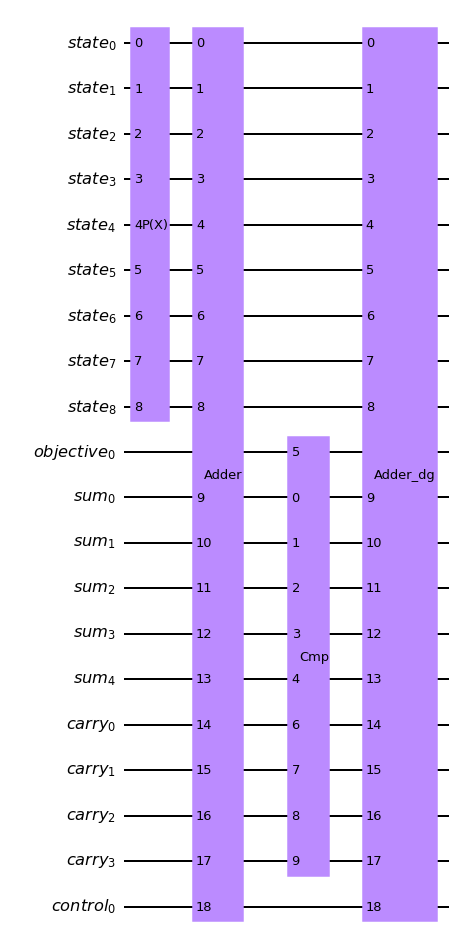

In [35]:
cdf_state_preparation.draw('mpl')

In [36]:
print('Estimated Value at Risk: $ {0:9,.0f}'.format(var * lgd_factor))
print('Exact Value at Risk: $ {0:9,.0f}'.format(exact_var * lgd_factor))

print('Estimated Probability:    %.3f' % estimated_probability)
print('Exact Probability:        %.3f' % cdf[exact_var])

Estimated Value at Risk: $   500,000
Exact Value at Risk: $   500,000
Estimated Probability:    0.918
Exact Probability:        0.918


# Lastly, get CVaR

Expected value of the loss conditional to it being larger than or equal to the VaR. To do so, we evaluate a piecewise linear objective function 𝑓(𝐿), dependent on the total loss 𝐿

$$ \begin{split} f(L) = \begin{cases} 0 & \text{if}\quad L \leq VaR \\L & \text{if}\quad L > VaR. \end{cases}\end{split} $$

To normalize, we have to divide the resulting expected value by the VaR-probabilit


In [37]:
var

5

In [38]:
breakpoints = [0, var]
slopes = [0, 1]
offsets = [0, 0]  # subtract VaR and add it later to the estimate
f_min = 0
f_max = sum(loss_given_default) - var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    weighted_adder.num_sum_qubits,
    slopes,
    offsets,
    domain=(0, 2**weighted_adder.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints
)

cvar_objective.draw()

┌─────────┐┌──────┐┌─────────┐┌─────────┐
q1896_0: ┤0        ├┤0     ├┤0        ├┤0        ├
         │         ││      ││         ││         │
q1896_1: ┤1        ├┤1     ├┤1        ├┤1        ├
         │         ││      ││         ││         │
q1896_2: ┤2        ├┤2     ├┤2        ├┤2        ├
         │  LinRot ││      ││  LinRot ││         │
q1896_3: ┤3        ├┤3     ├┤3        ├┤3        ├
         │         ││      ││         ││         │
q1896_4: ┤4        ├┤4     ├┤4        ├┤4        ├
         │         ││      ││         ││         │
q1897_0: ┤5        ├┤  cmp ├┤5        ├┤  cmp_dg ├
         └─────────┘│      │└────┬────┘│         │
   a6_0: ───────────┤5     ├─────■─────┤5        ├
                    │      │           │         │
   a6_1: ───────────┤6     ├───────────┤6        ├
                    │      │           │         │
   a6_2: ───────────┤7     ├───────────┤7        ├
                    │      │           │         │
   a6_3: ───────────┤8     ├───────────┤8        ├
                    │      │           │         │
   a6_4: ───────────┤9     ├───────────┤9        ├
                    └──────┘           └─────────┘

In [39]:
# define the registers for convenience and readability
cvar_qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
cvar_qr_sum = QuantumRegister(weighted_adder.num_sum_qubits, 'sum')
cvar_qr_carry = QuantumRegister(weighted_adder.num_carry_qubits, 'carry')
cvar_qr_obj = QuantumRegister(1, 'objective')
cvar_qr_work = QuantumRegister(cvar_objective.num_ancillas - len(cvar_qr_carry), 'work')

if weighted_adder.num_control_qubits > 0:
    cvar_qr_control = QuantumRegister(weighted_adder.num_control_qubits, 'control')
    cvar_state_preparation = QuantumCircuit(cvar_qr_state, cvar_qr_obj, cvar_qr_sum, cvar_qr_carry, cvar_qr_control, cvar_qr_work, name='A')
    cvar_state_preparation.append(uncertainty_model, cvar_qr_state)
    cvar_state_preparation.append(weighted_adder, cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:] + cvar_qr_control[:])
    cvar_state_preparation.append(cvar_objective, cvar_qr_sum[:] + cvar_qr_obj[:] + cvar_qr_carry[:] + cvar_qr_work[:])
    cvar_state_preparation.append(weighted_adder.inverse(), cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:] + cvar_qr_control[:])
else:
    cvar_state_preparation = QuantumCircuit(cvar_qr_state, cvar_qr_obj, cvar_qr_sum, cvar_qr_carry, cvar_qr_work, name='A')
    cvar_state_preparation.append(uncertainty_model, cvar_qr_state)
    cvar_state_preparation.append(weighted_adder, cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:])
    cvar_state_preparation.append(cvar_objective, cvar_qr_sum[:] + cvar_qr_obj[:] + cvar_qr_carry[:] + cvar_qr_work[:])
    cvar_state_preparation.append(weighted_adder.inverse(), cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:])

cvar_state_preparation.draw()


┌───────┐┌─────────┐       ┌────────────┐
    state_0: ┤0      ├┤0        ├───────┤0           ├
             │       ││         │       │            │
    state_1: ┤1      ├┤1        ├───────┤1           ├
             │       ││         │       │            │
    state_2: ┤2      ├┤2        ├───────┤2           ├
             │       ││         │       │            │
    state_3: ┤3      ├┤3        ├───────┤3           ├
             │       ││         │       │            │
    state_4: ┤4 P(X) ├┤4        ├───────┤4           ├
             │       ││         │       │            │
    state_5: ┤5      ├┤5        ├───────┤5           ├
             │       ││         │       │            │
    state_6: ┤6      ├┤6        ├───────┤6           ├
             │       ││         │       │            │
    state_7: ┤7      ├┤7        ├───────┤7           ├
             │       ││         │       │            │
    state_8: ┤8      ├┤8        ├───────┤8           ├
             └───────┘│         │┌─────┐│            │
objective_0: ─────────┤         ├┤5    ├┤            ├
                      │   adder ││     ││   adder_dg │
      sum_0: ─────────┤9        ├┤0    ├┤9           ├
                      │         ││     ││            │
      sum_1: ─────────┤10       ├┤1    ├┤10          ├
                      │         ││     ││            │
      sum_2: ─────────┤11       ├┤2    ├┤11          ├
                      │         ││     ││            │
      sum_3: ─────────┤12       ├┤3    ├┤12          ├
                      │         ││     ││            │
      sum_4: ─────────┤13       ├┤4    ├┤13          ├
                      │         ││   F ││            │
    carry_0: ─────────┤14       ├┤6    ├┤14          ├
                      │         ││     ││            │
    carry_1: ─────────┤15       ├┤7    ├┤15          ├
                      │         ││     ││            │
    carry_2: ─────────┤16       ├┤8    ├┤16          ├
                      │         ││     ││            │
    carry_3: ─────────┤17       ├┤9    ├┤17          ├
                      │         ││     ││            │
  control_0: ─────────┤18       ├┤     ├┤18          ├
                      └─────────┘│     │└────────────┘
     work_0: ────────────────────┤10   ├──────────────
                                 └─────┘

In [40]:
job = execute(cvar_state_preparation, backend=Aer.get_backend('statevector_simulator'))
value = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(cvar_qr_state) + 1)).format(i)[-(len(cvar_qr_state) + 1):]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == '1':
        value += am**2

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = (1.0 - estimated_probability)
v = value / d if d != 0 else 0
normalized_cvar = v + var
print('Estimated CVaR: $ {0:9,.0f}'.format(normalized_cvar * lgd_factor))
print('Exact CVaR: $ {0:9,.0f}'.format(exact_cvar * lgd_factor))

Estimated CVaR: $   846,200
Exact CVaR: $   683,348


In [41]:
# set target precision and confidence level
epsilon_iae = 0.01
alpha_iae = 0.05

# construct amplitude estimation
ae_cvar = IterativeAmplitudeEstimation(state_preparation=cvar_state_preparation,
                                       epsilon=epsilon_iae, alpha=alpha_iae,
                                       objective_qubits=[len(cvar_qr_state)],
                                       post_processing=cvar_objective.post_processing)
result_cvar = ae_cvar.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

In [42]:
# print results
d = (1.0 - estimated_probability)
v = result_cvar['estimation'] / d if d != 0 else 0
print('Estimated CVaR: $ {0:9,.0f}'.format((v + var) * lgd_factor))
print('Exact CVaR: $ {0:9,.0f}'.format(exact_cvar * lgd_factor))
print('Error: ', 1-(exact_cvar) / (v+var))

Estimated CVaR: $   874,195
Exact CVaR: $   683,348
Error:  0.21831127514733562
